Preprocessing Pipeline for Intracranial Aneurysm Detection

### Abstract
This pipeline implements a scanner-agnostic preprocessing framework for high-dimensional heterogeneous neuroimaging data (CTA & MRI). To address the 'domain shift' inherent in multi-site clinical data, we implement automated Hounsfield Unit (HU) standardization, N4 Bias Field Correction for magnetic inhomogeneity, and topology-preserving skull stripping via SynthStrip. This ensures downstream deep learning models receive standardized, artifact-free volumetric inputs, critical for identifying small vascular pathologies like aneurysms.

In [ ]:

import kagglehub
amirmmahdavikia_rsna2025_iad_metadata_path = kagglehub.dataset_download('amirmmahdavikia/rsna2025-iad-metadata')
amirmmahdavikia_synthstrip_pytorch_main_1_path = kagglehub.model_download('amirmmahdavikia/synthstrip/PyTorch/main/1')

print('Data source import complete.')

Data source import complete.


### ↓ Imports


----- Font -----

[Success] downloaded: carbonplus-regular-bl.otf
[Success] loaded.

----- Color -----



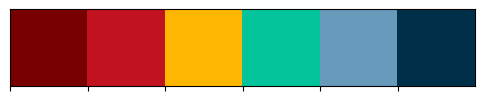

In [ ]:
import os
import sys
import re
import time
import math
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import nibabel as nib
import pydicom
import SimpleITK as sitk
from scipy.ndimage import zoom
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display_html, display, Markdown, IFrame
from ipywidgets.embed import embed_minimal_html
import warnings
import ast
import cv2
from tqdm.auto import tqdm
from glob import glob
import numpy as np
from typing import Tuple, Union, Optional, List


warnings.simplefilter(action='ignore', category=FutureWarning)

class clr:
    B = '\033[1m'
    L = '\033[1m' + '\033[94m'
    T = '\033[1m' + '\033[91m'
    E = '\033[0m'

print(clr.B+'\n----- Font -----\n'+clr.E)
font_url = 'https://raw.githubusercontent.com/ammomahdavikia/asset-holding/main/carbonplus-regular-bl.otf'
output_path = 'carbonplus-regular-bl.otf'

response = requests.get(font_url, stream=True)

if response.status_code == 200:
    with open(output_path, 'wb') as f:
        for chunk in response.iter_content(1024):
            f.write(chunk)
    print(f'[Success] downloaded: {output_path}')
else:
    print('[Error] Failed to download the font. Check the URL.')

font_path = '/kaggle/working/carbonplus-regular-bl.otf'
try:
    fm.fontManager.addfont(font_path)
    primary_font = fm.FontProperties(fname=font_path).get_name()
    plt.rcParams['font.family'] = [primary_font, "DejaVu Sans", "Noto Sans CJK JP"]
    print('[Success] loaded.')
except:
    print('[Error] Failed to load the font. Check the address.')

COLORS = ['#780000', '#c1121f', '#ffb703', '#02c39a', '#669bbc', '#003049']
modality_palette = {'MR': COLORS[3], 'CT': COLORS[4]}

print(clr.B+'\n----- Color -----\n'+clr.E)
sns.palplot(sns.color_palette(COLORS))

### ↓ Libraries

In [ ]:
%%capture
!pip install nipreps-synthstrip
!pip install nipreps-synthstrip[nipype]

In [ ]:
CONFIG = {
    'PATH': '/kaggle/input/rsna-intracranial-aneurysm-detection',
    'META': '/kaggle/input/rsna2025-iad-metadata',
    'IMG_SIZE': (196, 196),
    'ARTERIES': {
        1: "Other Posterior Circulation",
        2: "Basilar Tip",
        3: "Right Posterior Communicating Artery",
        4: "Left Posterior Communicating Artery",
        5: "Right Infraclinoid Internal Carotid Artery",
        6: "Left Infraclinoid Internal Carotid Artery",
        7: "Right Supraclinoid Internal Carotid Artery",
        8: "Left Supraclinoid Internal Carotid Artery",
        9: "Right Middle Cerebral Artery",
        10: "Left Middle Cerebral Artery",
        11: "Right Anterior Cerebral Artery",
        12: "Left Anterior Cerebral Artery",
        13: "Anterior Communicating Artery"
    },
}

fig_dir = 'figures'
os.makedirs(fig_dir, exist_ok=True)

### ↓ Helpers

In [ ]:
def load_dicom(dir_path: str) -> np.ndarray:
    """
    Load DICOM images from a directory and return as a 3D NumPy array.
    Automatically determines the slice orientation (sagittal, coronal, axial)
    from the first file and sorts slices accordingly.

    Memory Note: For large-scale processing, ensure output array is cast to
    float32 or uint8 to minimize memory footprint on HPC clusters.

    Args:
        dir_path (str): Path to directory containing .dcm files

    Returns:
        np.ndarray: 3D volume
    """
    dcm_files = sorted(glob(os.path.join(dir_path, "*.dcm")))
    if not dcm_files:
        raise ValueError(f"No DICOM files found in {dir_path}")

    first_dcm = pydicom.dcmread(dcm_files[0])
    iop = getattr(first_dcm, "ImageOrientationPatient", None)
    if iop is None or len(iop) < 6:
        raise ValueError("ImageOrientationPatient tag missing or malformed")

    row_cosines = np.array(iop[0:3])
    col_cosines = np.array(iop[3:6])
    normal = np.cross(row_cosines, col_cosines)

    dim = int(np.argmax(np.abs(normal)))
    plane_map = {0: "sagittal", 1: "coronal", 2: "axial"}
    plane = plane_map[dim]

    if len(dcm_files) == 1:
        if hasattr(first_dcm, "NumberOfFrames"):
            return first_dcm.pixel_array
        else:
            return np.expand_dims(first_dcm.pixel_array, axis=0)
    else:
        slices = [pydicom.dcmread(f) for f in dcm_files]
        try:
            slices.sort(key=lambda s: int(s.InstanceNumber))
        except (AttributeError, ValueError):
            slices.sort(key=lambda s: float(s.ImagePositionPatient[dim]))

        volume = np.stack([s.pixel_array for s in slices], axis=0)
        return volume

def load_nii(path: str, mask: bool = False) -> np.ndarray:
    """
    Loads NIfTI file and ensures canonical orientation.
    """
    series_id = os.path.basename(os.path.dirname(path))
    nii = nib.load(path)
    nii = nib.as_closest_canonical(nii)
    nii_array = nii.get_fdata()  # convert to numpy array

    if mask:
        nii_array = np.clip(nii_array, 0, 13).astype(np.uint8)

    nii_array = nii_array[::-1, :, :]
    nii_array = np.rot90(nii_array, k=1, axes=(0, 1))
    nii_array = np.transpose(nii_array, (2, 0, 1))
    nii_array = np.ascontiguousarray(nii_array)

    return nii_array

def plot_image_slices(image_array, save_path, cmap='gray'):

    num_slices = image_array.shape[0]

    cols = math.ceil(math.sqrt(num_slices))
    rows = math.ceil(num_slices / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    axes = axes.ravel()

    for i in range(rows*cols):
        ax = axes[i]
        if i < num_slices:
            ax.imshow(image_array[i, :, :], cmap=cmap)
            ax.set_title(i)
        ax.axis('off')

    fig.tight_layout()
    fig.savefig(os.path.join(fig_dir, save_path+'.png'), dpi=300)
    fig.show()

def plot_preprocessing_process(processes):
    fig, axs = plt.subplots(1, len(processes), figsize=(len(processes)*3, 3))

    for idx, (process, array) in enumerate(processes.items()):
        if 'resample' in process.lower():
            if 'mask' in process.lower():
                resample_selected_slice = array.mean(axis=(1, 2)).argmax()
            else:
                resample_selected_slice = array.shape[0] * 2 // 3
        else:
            if 'mask' in process.lower():
                normal_selected_slice = array.mean(axis=(1, 2)).argmax()
            else:
                normal_selected_slice = array.shape[0] * 2 // 3

    for idx, (process, array) in enumerate(processes.items()):
        if 'resample' in process.lower():
            selected_slice = resample_selected_slice
        else:
            selected_slice = normal_selected_slice

        cmap='gray'
        if 'mask' in process.lower():
            cmap='jet'

        axs[idx].imshow(array[selected_slice, :, :], cmap=cmap)
        axs[idx].axis('off')
        axs[idx].set_title(f'{process}\n{array.shape}')

    fig.tight_layout()
    plt.show()

# <div style="text-align:center; border-radius:10px; color:black; margin:0; font-size:200%; font-family:Carbon Plus; background-color:white; overflow:hidden"><b>Load the Data</b></div>

In [ ]:
def load_data(metadata=False):

    if metadata:
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        train_df = pd.read_csv(os.path.join(CONFIG['META'], 'train.csv'))
        train_loc = pd.read_csv(os.path.join(CONFIG['META'], 'train_localizers.csv'))
        train_instances = pd.read_csv(os.path.join(CONFIG['META'], 'train_instances.csv'))
        return train_df, train_loc, train_instances
    else:
        train_df = pd.read_csv(os.path.join(CONFIG['PATH'], 'train.csv'))
        train_loc = pd.read_csv(os.path.join(CONFIG['PATH'], 'train_localizers.csv'))
        return train_df, train_loc

def summarize(df, desc='Summary'):

    start = clr.T
    if 'Localization' in desc:
        start = clr.L

    print(start+f'\n----- {desc} -----\n'+clr.E)
    print(clr.B+'Shape:'+clr.E, df.shape)
    print(clr.B+'Missing:'+clr.E, df.isna().sum().sum())
    print(clr.B+'Columns:\n'+clr.E, df.columns.to_list())
    display_html(df.head(3))
    print('\n')

In [ ]:
train_df, train_loc, train_instances = load_data(metadata=True)

for df, desc in zip([train_df, train_instances, train_loc],
                    ['New Train', 'Instances', 'New Localization']):
    summarize(df, desc)


----- New Train -----

Shape: (4348, 25)
Missing: 532
Columns:
 ['SeriesInstanceUID', 'PatientAge', 'PatientSex', 'Modality', 'Left Infraclinoid Internal Carotid Artery', 'Right Infraclinoid Internal Carotid Artery', 'Left Supraclinoid Internal Carotid Artery', 'Right Supraclinoid Internal Carotid Artery', 'Left Middle Cerebral Artery', 'Right Middle Cerebral Artery', 'Anterior Communicating Artery', 'Left Anterior Cerebral Artery', 'Right Anterior Cerebral Artery', 'Left Posterior Communicating Artery', 'Right Posterior Communicating Artery', 'Basilar Tip', 'Other Posterior Circulation', 'Aneurysm Present', 'FrameOfReferenceUID', 'SOPClassUID', 'IsMultiFrame', 'Rows', 'Columns', 'NumberOfFrames', 'Plane']


,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,...,Basilar Tip,Other Posterior Circulation,Aneurysm Present,FrameOfReferenceUID,SOPClassUID,IsMultiFrame,Rows,Columns,NumberOfFrames,Plane
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,64,Female,MRA,0,0,0,0,0,0,...,0,0,0,1.2.826.0.1.3680043.10.474.2.966396.18197,1.2.840.10008.5.1.4.1.1.4,False,512,512,188,axial
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,76,Female,MRA,0,0,0,0,0,0,...,0,0,0,1.2.826.0.1.3680043.10.474.2.961980.15432,1.2.840.10008.5.1.4.1.1.4,False,512,512,147,axial
2,1.2.826.0.1.3680043.8.498.10005158603912009425...,58,Male,CTA,0,0,0,0,0,0,...,0,1,1,1.2.826.0.1.3680043.10.474.2.961932.13226,1.2.840.10008.5.1.4.1.1.2,False,512,512,276,axial





----- Instances -----

Shape: (1028811, 34)
Missing: 3733069
Columns:
 ['SeriesInstanceUID', 'FrameOfReferenceUID', 'SOPClassUID', 'SOPInstanceUID', 'FilePath', 'Modality', 'Columns', 'Rows', 'PixelRepresentation', 'BitsAllocated', 'BitsStored', 'HighBit', 'RescaleIntercept', 'RescaleSlope', 'RescaleType', 'SliceThickness', 'SpacingBetweenSlices', 'PixelSpacing_X', 'PixelSpacing_Y', 'IPP_X', 'IPP_Y', 'IPP_Z', 'IOP_RowX', 'IOP_RowY', 'IOP_RowZ', 'IOP_ColX', 'IOP_ColY', 'IOP_ColZ', 'Plane', 'InstanceNumber', 'WindowWidth1', 'WindowWidth2', 'WindowCenter1', 'WindowCenter2']


,SeriesInstanceUID,FrameOfReferenceUID,SOPClassUID,SOPInstanceUID,FilePath,Modality,Columns,Rows,PixelRepresentation,BitsAllocated,...,IOP_RowZ,IOP_ColX,IOP_ColY,IOP_ColZ,Plane,InstanceNumber,WindowWidth1,WindowWidth2,WindowCenter1,WindowCenter2
0,1.2.826.0.1.3680043.8.498.96155132589464464482...,1.2.826.0.1.3680043.10.474.2.962274.4328,1.2.840.10008.5.1.4.1.1.4,1.2.826.0.1.3680043.8.498.12917525362614753713...,/kaggle/input/rsna-intracranial-aneurysm-detec...,MR,392,448,1,16,...,-0.032261,-0.04882,0.997593,0.049252,axial,1,1103.0,NaN,533.0,NaN
1,1.2.826.0.1.3680043.8.498.96155132589464464482...,1.2.826.0.1.3680043.10.474.2.962274.4328,1.2.840.10008.5.1.4.1.1.4,1.2.826.0.1.3680043.8.498.22269960287053823144...,/kaggle/input/rsna-intracranial-aneurysm-detec...,MR,392,448,1,16,...,-0.032261,-0.04882,0.997593,0.049252,axial,2,1069.0,NaN,510.0,NaN
2,1.2.826.0.1.3680043.8.498.96155132589464464482...,1.2.826.0.1.3680043.10.474.2.962274.4328,1.2.840.10008.5.1.4.1.1.4,1.2.826.0.1.3680043.8.498.28020357893927359210...,/kaggle/input/rsna-intracranial-aneurysm-detec...,MR,392,448,1,16,...,-0.032261,-0.04882,0.997593,0.049252,axial,3,1101.0,NaN,525.0,NaN





----- New Localization -----

Shape: (2251, 10)
Missing: 0
Columns:
 ['SeriesInstanceUID', 'SOPInstanceUID', 'coordinates', 'location', 'x', 'y', 'Rows', 'Columns', 'x_norm', 'y_norm']


,SeriesInstanceUID,SOPInstanceUID,coordinates,location,x,y,Rows,Columns,x_norm,y_norm
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,"{'x': 258.3621186176837, 'y': 261.359900373599}",Other Posterior Circulation,258.362119,261.359900,512,512,0.504614,0.510469
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,"{'x': 194.87253141831238, 'y': 178.32675044883...",Right Middle Cerebral Artery,194.872531,178.326750,512,512,0.380610,0.348294
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,"{'x': 189.23979878597123, 'y': 209.19184886465...",Right Middle Cerebral Artery,189.239799,209.191849,512,512,0.369609,0.408578


# <div style="text-align:center; border-radius:10px; color:black; margin:0; font-size:200%; font-family:Carbon Plus; background-color:white; overflow:hidden"><b>CT Modality Processing</b></div>

### Scientific Rationale: Standardization
For Computed Tomography (CT), pixel intensities correspond to radiodensity units (Hounsfield Units). However, raw DICOM data often contains varying intercepts and slopes.

**Why this matters:** A deep learning model trained on uncalibrated data may learn to detect specific scanner artifacts rather than true pathology. By rigorously enforcing HU Windowing and Resampling, we ensure the model learns generalized features of the intracranial vasculature.

We apply:
+ **HU Windowing** – to focus on relevant intensity ranges of intracranial arteries (100-600 HU).
+ **Intensity Normalization** – to standardize voxel values across scans.
+ **Resampling** – to achieve uniform spatial resolution (Isotropic 1mm).

Let's start with a series. I will use a series supporting segmentations for the sake of better visualization.

In [ ]:
seg_dir = os.path.join(CONFIG['PATH'], 'segmentations')
seg_series = [re.sub(r'(_cowseg)?\.nii$', '', f) for f in os.listdir(seg_dir)]
seg_df = train_df[train_df.SeriesInstanceUID.isin(seg_series)]
all_ct_series_uids = seg_df[seg_df.Modality=='CTA'].SeriesInstanceUID.tolist()

def summarize_series(series_uid, desc='Summary'):

    print(clr.B+'Chosen series_uid:'+clr.E)
    print(ct_series_uid)
    print(clr.B+'\nAge:'+clr.E)
    print(f'{train_df[train_df.SeriesInstanceUID == series_uid].PatientAge.iloc[0]}')
    print(clr.B+'\nSex:'+clr.E)
    print(f'{train_df[train_df.SeriesInstanceUID == series_uid].PatientSex.iloc[0]}')
    print(clr.B+'\nHas Aneurysm:'+clr.E)
    print(f'{train_df[train_df.SeriesInstanceUID == series_uid]["Aneurysm Present"].iloc[0]}')

In [ ]:
ct_series_uid = '1.2.826.0.1.3680043.8.498.52363954882447190271251269039176558430'
#ct_series_uid = np.random.choice(all_ct_series_uids)
summarize_series(ct_series_uid)

Chosen series_uid:
1.2.826.0.1.3680043.8.498.52363954882447190271251269039176558430

Age:
63

Sex:
Female

Has Aneurysm:
1


In [ ]:
ct_series_dir = os.path.join(CONFIG['PATH'], 'series', ct_series_uid)
ct_series_array = load_dicom(ct_series_dir)
print(clr.B+'Image shape:'+clr.E)
print(ct_series_array.shape)

Image shape:
(60, 512, 512)


In [ ]:
plot_image_slices(ct_series_array, save_path='ct_series_wo_preprocessing')

In [ ]:
ct_mask_path = os.path.join(seg_dir, ct_series_uid+'_cowseg.nii')
ct_mask_array = load_nii(ct_mask_path)
print(clr.B+'Mask shape:'+clr.E)
print(ct_mask_array.shape)

Mask shape:
(60, 512, 512)


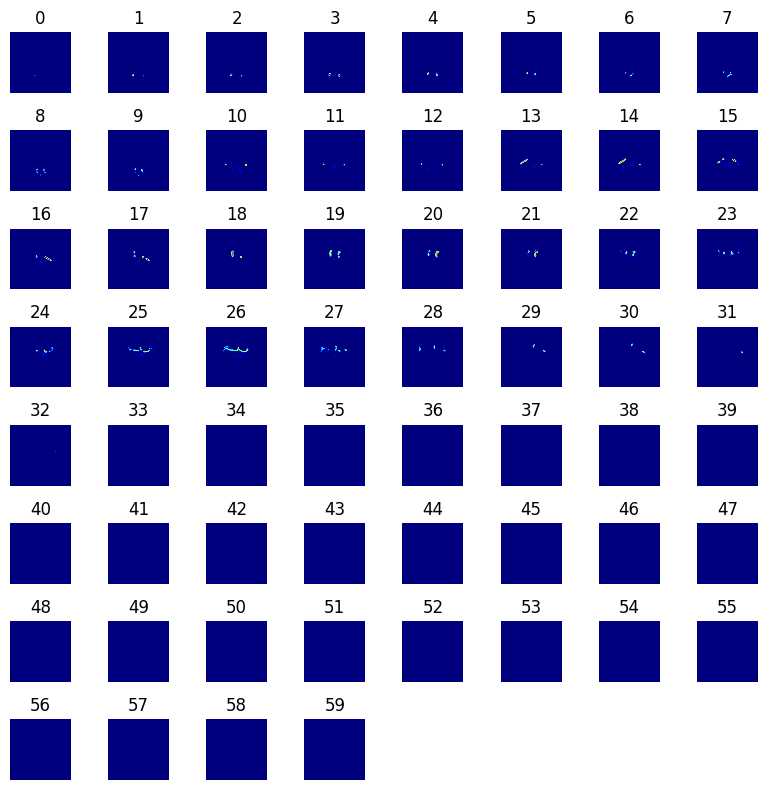

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plot_image_slices(ct_mask_array, save_path='ct_mask_wo_preprocessing', cmap='jet')

## HU Scaling

Standardizing HU ranges is critical for model generalization. Without this, a deep learning model might overfit to specific scanner calibration settings rather than learning the underlying pathology of the aneurysm.

$$
\text{HU} = 1000 \times \frac{\mu_\text{material} - \mu_\text{water}}{\mu_\text{water}}
$$


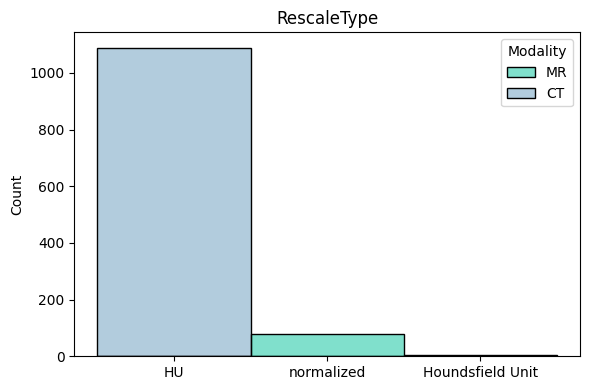

In [ ]:
scales = train_instances.groupby(
    ['SeriesInstanceUID', 'Modality']
).agg({
    'RescaleSlope': 'mean',
    'RescaleIntercept': 'mean',
    'RescaleType': 'first'
}).reset_index()


fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    scales,
    x='RescaleType',
    hue='Modality',
    palette=modality_palette,
    ax=ax
)
ax.set_title('RescaleType')
ax.set_xlabel('')

fig.tight_layout()
fig.show()

### Hounsfield Rescale

#### [DICOM] **RescaleSlope** & **RescaleIntercept**
The general HU rescale formula is:

$$\text{HU} = (\text{RawPixelValue} \times \text{RescaleSlope}) + \text{RescaleIntercept}$$

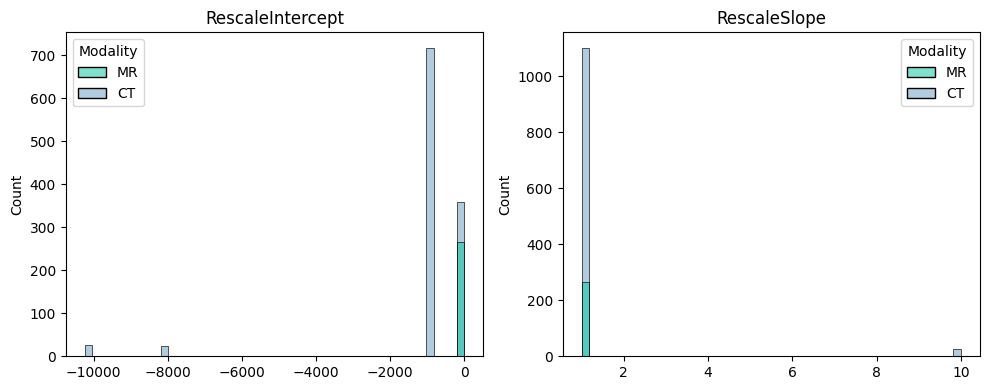

In [ ]:
rscles = ['RescaleIntercept', 'RescaleSlope']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axs = axs.flatten()

for idx, rscle in enumerate(rscles):
    sns.histplot(
        scales,
        x=rscle,
        hue='Modality',
        palette=modality_palette,
        ax=axs[idx],
        bins=50
    )
    axs[idx].set_title(rscle)
    axs[idx].set_xlabel('')

fig.tight_layout()
fig.show()
fig.savefig('figures/Rescale_distribution.png', dpi=300)

In [ ]:
pd.DataFrame(scales[scales.Modality == 'CT'].value_counts(['RescaleSlope', 'RescaleIntercept']))

count
RescaleSlope RescaleIntercept       
1.0          -1024.0             718
              0.0                359
10.0         -10240.0             27
1.0          -8192.0              24

#### Calibration Analysis
As seen above, slope/intercept values vary across the cohort. Automated reading of these tags is essential for robust preprocessing.

In [ ]:
def apply_hounsfield_scaling(
    array: np.ndarray,
    slope: float,
    intercept: float
) -> np.ndarray:

    if slope is not None and intercept is not None:
        rescaled_array = array * slope + intercept
    else:
        rescaled_array = array

    return rescaled_array

For isolating intracranial arteries and aneurysms on CTA, a Hounsfield unit range of **100–600** HU was selected. This range effectively captures contrast-enhanced arterial blood, highlighting both normal vessels and aneurysmal dilatations, while excluding most surrounding soft tissue and bone.

In [ ]:
def apply_hounsfield_range(array: np.ndarray, hounsfield_range: Tuple[int, int] = (100, 600)) -> np.ndarray:
    mask = (array >= hounsfield_range[0]) & (array <= hounsfield_range[1])
    range_array = np.where(mask, array, 0)
    return range_array

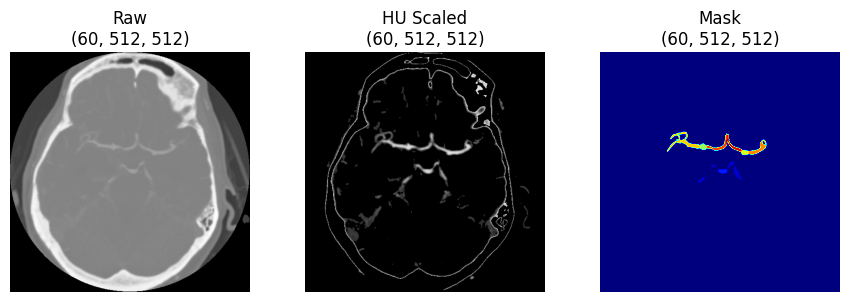

RescaleSlope:
1

RescaleIntercept:
0

Raw pixel values (5x5):
[[-2048 -2048 -2048 -2048 -2048]
 [-2048 -2048 -2048 -2048 -2048]
 [-2048 -2048 -2048 -2048 -2048]
 [-2048 -2048 -2048 -2048 -2048]
 [-2048 -2048 -2048 -2048 -2048]]
Mean: -457.6 Max: 2358 Min: -2048

Rescaled pixel values (HU, 5x5):
[[-2048. -2048. -2048. -2048. -2048.]
 [-2048. -2048. -2048. -2048. -2048.]
 [-2048. -2048. -2048. -2048. -2048.]
 [-2048. -2048. -2048. -2048. -2048.]
 [-2048. -2048. -2048. -2048. -2048.]]
Mean: -457.6 Max: 2358.0 Min: -2048.0


In [ ]:
ct_dcm = pydicom.dcmread(glob(os.path.join(ct_series_dir, '*.dcm'))[0])
slope = ct_dcm.get('RescaleSlope')
intercept = ct_dcm.get('RescaleIntercept')
modality = ct_dcm.get('Modality')
assert modality == 'CT', f'series_uid :{ct_series_uid} should be CT.'
ct_rescaled_array = apply_hounsfield_scaling(ct_series_array, slope=slope, intercept=intercept)
ct_range_array = apply_hounsfield_range(ct_rescaled_array, hounsfield_range=(100, 600))

plot_preprocessing_process({
    'Raw': ct_series_array,
    'HU Scaled': ct_range_array,
    'Mask': ct_mask_array
})

print(clr.B+'RescaleSlope:'+clr.E)
print(slope)
print(clr.B+'\nRescaleIntercept:'+clr.E)
print(intercept)
print(clr.L+"\nRaw pixel values (5x5):"+clr.E)
print(ct_series_array[ct_series_array.shape[0]*2//3, :5, :5])
print(clr.L+'Mean:'+clr.E, ct_series_array.mean().round(2), clr.L+'Max:'+clr.E, ct_series_array.max(), clr.L+'Min:'+clr.E, ct_series_array.min())
print(clr.T+"\nRescaled pixel values (HU, 5x5):"+clr.E)
print(ct_rescaled_array[ct_rescaled_array.shape[0]*2//3, :5, :5])
print(clr.T+'Mean:'+clr.E, ct_rescaled_array.mean().round(2), clr.T+'Max:'+clr.E, ct_rescaled_array.max(), clr.T+'Min:'+clr.E, ct_rescaled_array.min())

In [ ]:
def plot_hounsfield_interactive(array):
    mid_slice = array.shape[0] * 2 // 3

    hu_min_slider = widgets.IntSlider(value=100, min=-1000, max=3000, step=10, description='HU Min')
    hu_max_slider = widgets.IntSlider(value=600, min=-1000, max=3000, step=10, description='HU Max')

    out = widgets.Output()

    def update(hu_min, hu_max):
        mask = (array >= hu_min) & (array <= hu_max)
        filtered_array = np.where(mask, array, 0)

        with out:
            out.clear_output(wait=True)
            fig, axs = plt.subplots(1, 3, figsize=(8, 4))

            axs[0].imshow(array[mid_slice], cmap='gray')
            axs[0].axis('off')
            axs[0].set_title("Raw HU")

            axs[1].imshow(filtered_array[mid_slice], cmap='gray')
            axs[1].axis('off')
            axs[1].set_title(f"Filtered {hu_min}–{hu_max} HU")

            axs[2].imshow(ct_mask_array[mid_slice], cmap='jet')
            axs[2].axis('off')
            axs[2].set_title("Segmentation")

            plt.tight_layout()
            plt.show()

    widgets.interactive(update, hu_min=hu_min_slider, hu_max=hu_max_slider)

    update(hu_min_slider.value, hu_max_slider.value)

    ui = widgets.VBox([hu_min_slider, hu_max_slider, out])

    embed_minimal_html('hu_widget.html', views=[ui], title='HU Windowing')
    display(IFrame(src='hu_widget.html', width=900, height=600))

In [ ]:
plot_hounsfield_interactive(ct_rescaled_array)

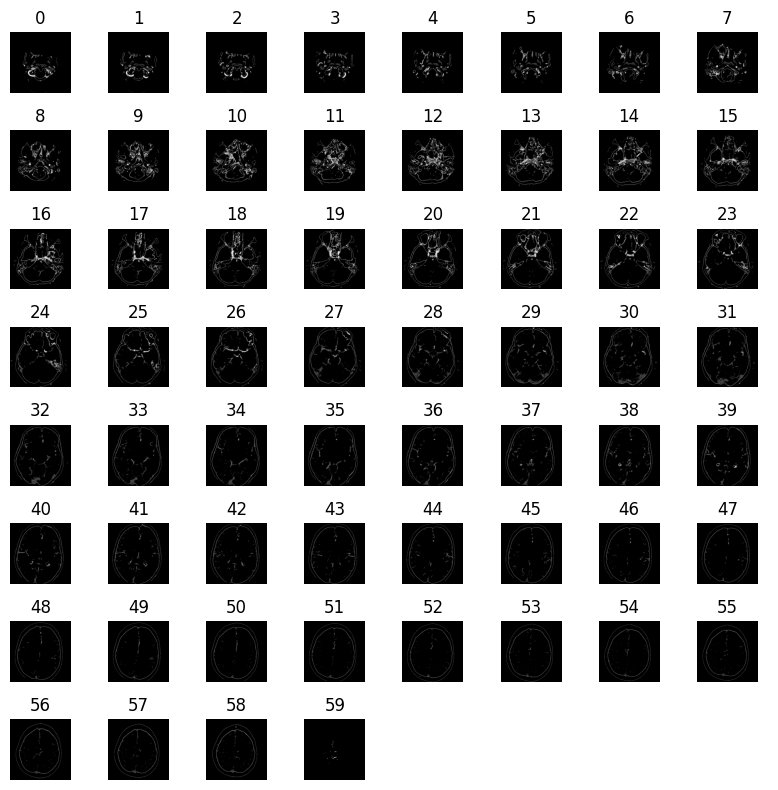

In [ ]:
plot_image_slices(ct_range_array, save_path='ct_series_w_hounsfield_scaling')

## [CT] Intensity Normalization

After scaling, normalize the intensities is a way to ensure consistency across images. It can be done in multiple ways:

+ **Z-score Normalization**
+ **Min-Max normalization**

In [ ]:
def apply_normalization(array: np.ndarray, norm: str = 'z-score') -> np.ndarray:
    if norm == 'min-max':
        return (array - array.min()) / (array.max() - array.min() + 1e-8)
    elif norm == 'z-score':
        return (array - array.mean()) / array.std()

In [ ]:
ct_z_normalized_array = apply_normalization(ct_range_array, 'z-score')

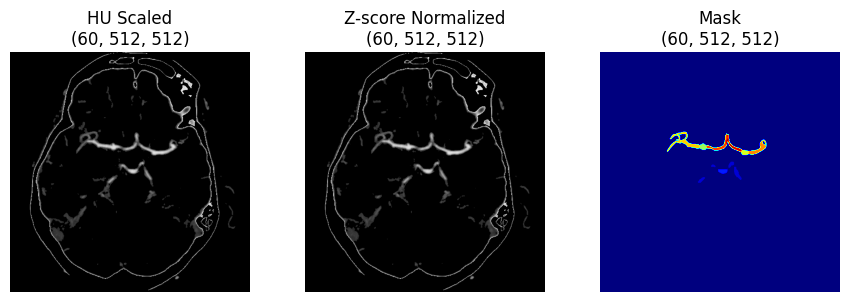

In [ ]:
plot_preprocessing_process({
    'HU Scaled': ct_range_array,
    'Z-score Normalized': ct_z_normalized_array,
    'Mask': ct_mask_array
})

In [ ]:
ct_mm_normalized_array = apply_normalization(ct_range_array, 'min-max')

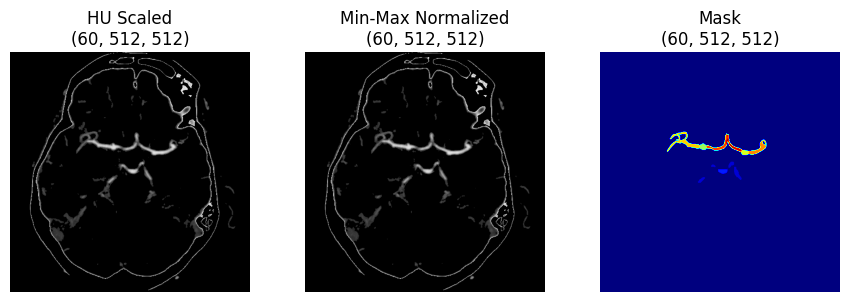

In [ ]:
plot_preprocessing_process({
    'HU Scaled': ct_range_array,
    'Min-Max Normalized': ct_mm_normalized_array,
    'Mask': ct_mask_array
})

## [CT] Resampling

Resampling is the process of changing the voxel grid of an image to a new spacing, orientation, or size. It’s used for standardizing datasets (e.g., same voxel spacing across scans). It makes sure that pixels in the dataset share same spatial grid.


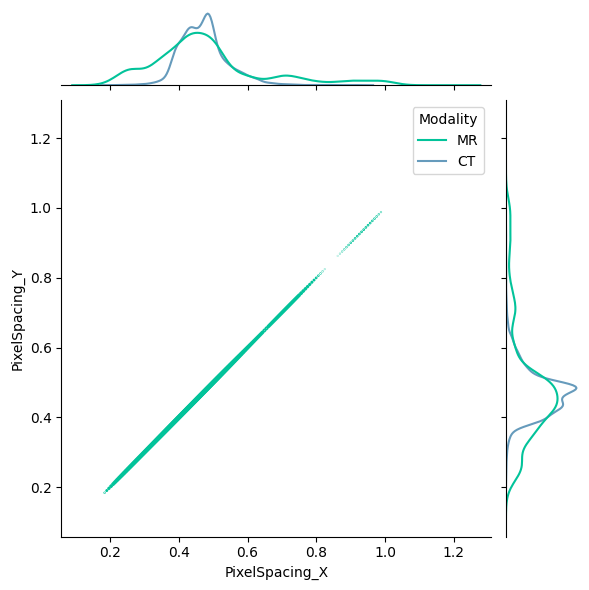

In [ ]:
pixels = train_instances.groupby(['SeriesInstanceUID', 'Modality'])[['PixelSpacing_X', 'PixelSpacing_Y']].mean().reset_index()

g = sns.jointplot(
    data=pixels,
    x="PixelSpacing_X",
    y="PixelSpacing_Y",
    hue='Modality',
    kind='kde',
    palette=modality_palette,
    height=6
)

g.figure.savefig('figures/pixel_spacing_distribution.png', dpi=300)
plt.show()

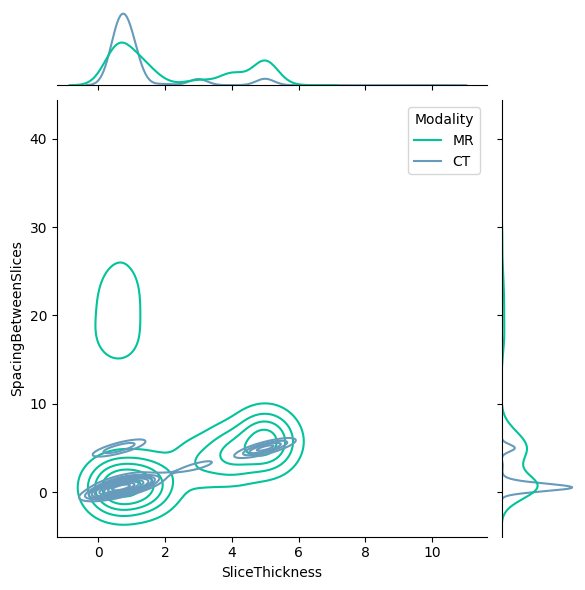

In [ ]:
slices = train_instances.groupby(['SeriesInstanceUID', 'Modality'])[['SliceThickness', 'SpacingBetweenSlices']].mean().reset_index()

g = sns.jointplot(
    data=slices,
    x="SliceThickness",
    y="SpacingBetweenSlices",
    hue='Modality',
    palette=modality_palette,
    kind='kde',
    height=6
)

g.figure.savefig('figures/slice_dimensions_distribution.png', dpi=300)
plt.show()

In this work, we will use a **target spacing** of `(1.0, 1.0, 1.0)` mm for resampling. However, determining the optimal spacing can be approached in several ways, such as analyzing the original voxel dimensions across the dataset. Choosing the appropriate spacing is crucial, as it affects both the accuracy of downstream analysis and the memory requirements during processing.

In [ ]:
def apply_resampling(
    array: np.ndarray,
    pixel_spacing_x: float,
    pixel_spacing_y: float,
    pixel_spacing_z: float,
    target_spacing: Tuple[float, float, float] = (1.0, 1.0, 1.0),
    is_mask: bool = False
) -> np.ndarray:
    """
    Resample a 3D array to target spacing.
    Ensures isotropic resolution for 3D CNNs.

    Parameters
    ----------
    array : np.ndarray
        Input array with shape (Z, H, W)
    pixel_spacing_x, pixel_spacing_y, pixel_spacing_z : float
        Original voxel spacing in mm
    target_spacing : tuple of float
        Desired spacing (x, y, z) in mm
    is_mask : bool
        If True, use nearest neighbor interpolation to preserve labels

    Returns
    -------
    resampled_array : np.ndarray
        Resampled array with same type as input
    """
    # Transpose to (W, H, Z) for scipy zoom
    array = np.transpose(array, (2, 1, 0))
    pixdim = [pixel_spacing_x, pixel_spacing_y, pixel_spacing_z]
    zoom_factors = tuple(pixdim[i] / target_spacing[i] for i in range(3))

    order = 0 if is_mask else 3  # nearest neighbor for mask, cubic for image

    resampled_array = zoom(array, zoom_factors, order=order)
    # Transpose back to original (Z, H, W)
    resampled_array = np.transpose(resampled_array, (2, 1, 0))

    if is_mask:
        resampled_array = resampled_array.astype(array.dtype)

    return resampled_array

In [ ]:
ct_pixel_spacing = ct_dcm.get('PixelSpacing')
ct_slice_thickness = ct_dcm.get('SliceThickness')
ct_spacing_slices = ct_dcm.get('SpacingBetweenSlices')

print(clr.B+'PixelSpacing:'+clr.E)
print(ct_pixel_spacing)
print(clr.B+'\nSliceThickness:'+clr.E)
print(ct_slice_thickness)
print(clr.B+'\nSpacingBetweenSlices:'+clr.E)
print(ct_spacing_slices)

PixelSpacing:
[0.351000, 0.351000]

SliceThickness:
2.000

SpacingBetweenSlices:
None


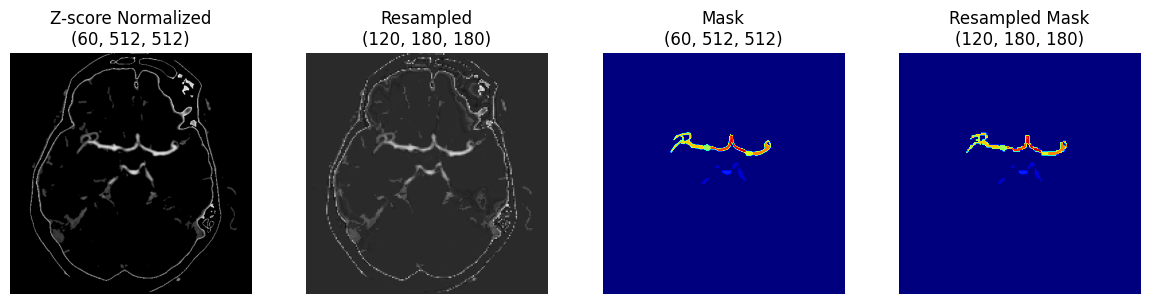

Raw array:
Shape: (60, 512, 512)
Mean: 0.0 Max: 8.28 Min: -0.22

Resampled array:
Shape: (120, 180, 180)
Mean: -0.0 Max: 11.01 Min: -4.99


In [ ]:
ct_resampled_array = apply_resampling(
    ct_z_normalized_array,
    pixel_spacing_x=ct_pixel_spacing[0],
    pixel_spacing_y=ct_pixel_spacing[1],
    pixel_spacing_z=ct_spacing_slices if ct_spacing_slices else ct_slice_thickness,
    target_spacing=(1.0, 1.0, 1.0)
)

ct_resampled_mask = apply_resampling(
    ct_mask_array,
    pixel_spacing_x=ct_pixel_spacing[0],
    pixel_spacing_y=ct_pixel_spacing[1],
    pixel_spacing_z=ct_spacing_slices if ct_spacing_slices else ct_slice_thickness,
    target_spacing=(1.0, 1.0, 1.0),
    is_mask=True
)

plot_preprocessing_process({
    'Z-score Normalized': ct_z_normalized_array,
    'Resampled': ct_resampled_array,
    'Mask': ct_mask_array,
    'Resampled Mask': ct_resampled_mask
})

print(clr.L+"Raw array:"+clr.E)
print(clr.L+'Shape:'+clr.E, ct_z_normalized_array.shape)
print(clr.L+'Mean:'+clr.E, ct_z_normalized_array.mean().round(2), clr.L+'Max:'+clr.E, ct_z_normalized_array.max().round(2), clr.L+'Min:'+clr.E, ct_z_normalized_array.min().round(2))
print(clr.T+"\nResampled array:"+clr.E)
print(clr.T+'Shape:'+clr.E, ct_resampled_array.shape)
print(clr.T+'Mean:'+clr.E, ct_resampled_array.mean().round(2), clr.T+'Max:'+clr.E, ct_resampled_array.max().round(2), clr.T+'Min:'+clr.E, ct_resampled_array.min().round(2))

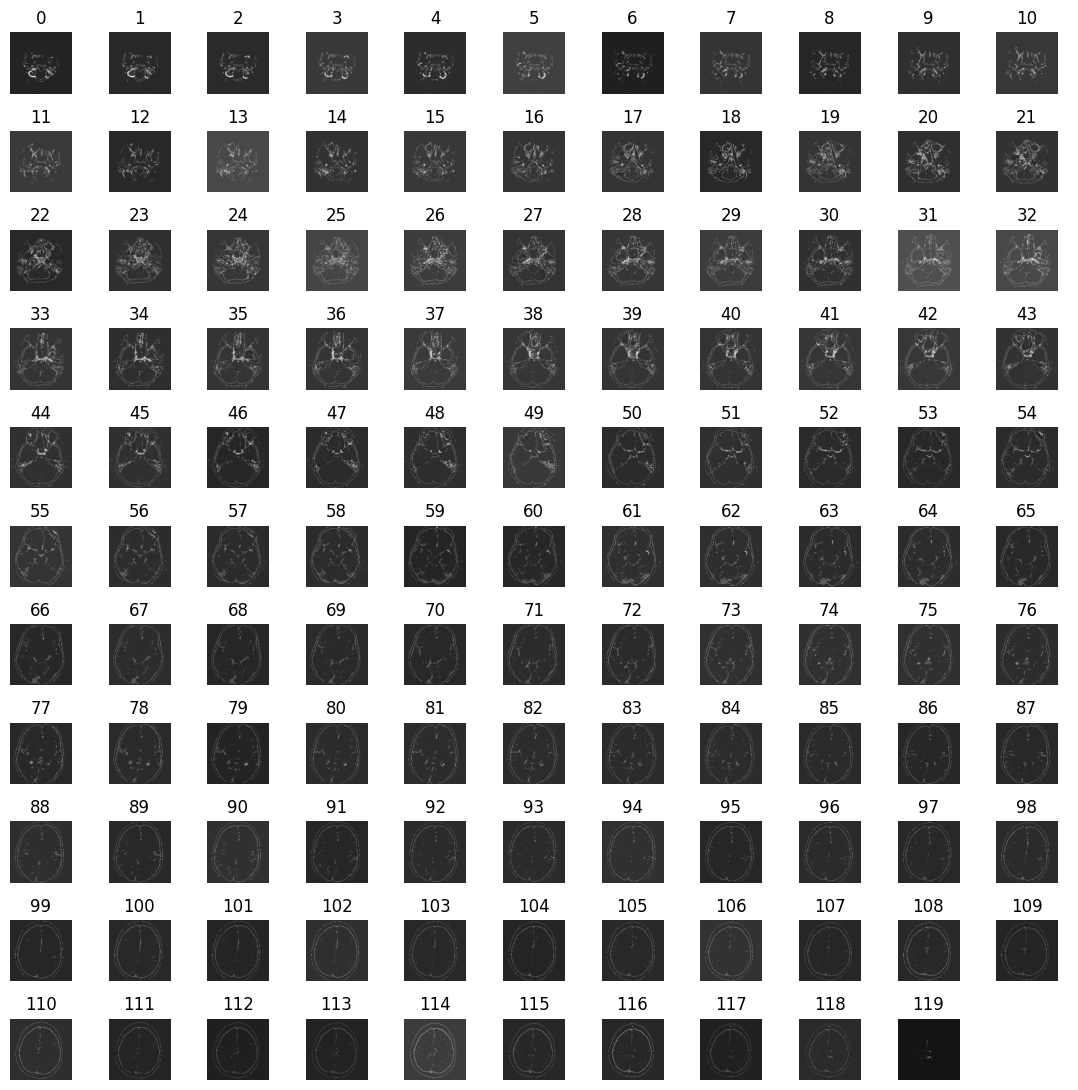

In [ ]:
plot_image_slices(ct_resampled_array, 'ct_series_w_resampling')

## [CT] Process

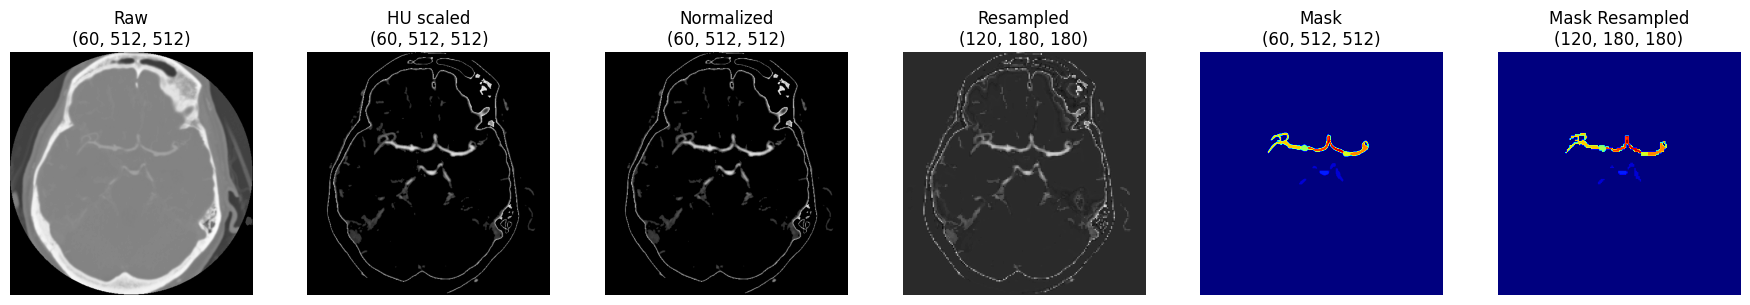

In [ ]:
plot_preprocessing_process({
    'Raw': ct_series_array,
    'HU scaled': ct_range_array,
    'Normalized': ct_z_normalized_array,
    'Resampled': ct_resampled_array,
    'Mask': ct_mask_array,
    'Mask Resampled': ct_resampled_mask
})

# <div style="text-align:center; border-radius:10px; color:black; margin:0; font-size:200%; font-family:Carbon Plus; background-color:white; overflow:hidden"><b>MR Modality Processing</b></div>

### Scientific Rationale: Bias Field Correction
Intensity inhomogeneity (bias field) can mimic the appearance of diffuse pathology or obscure small aneurysms. By applying N4 correction, we remove low-frequency intensity gradients caused by coil sensitivity, ensuring that the 'fingerprint' of the tissue remains consistent across the cohort.

In [ ]:
all_mr_series_uids = seg_df[seg_df.Modality!='CTA'].SeriesInstanceUID.tolist()

In [ ]:
mr_series_uid = '1.2.826.0.1.3680043.8.498.92498800238576582506105430510381134234'
#mr_series_uid = np.random.choice(all_mr_series_uids)
summarize_series(mr_series_uid)

Chosen series_uid:
1.2.826.0.1.3680043.8.498.52363954882447190271251269039176558430

Age:
77

Sex:
Male

Has Aneurysm:
0


In [ ]:
mr_series_dir = os.path.join(CONFIG['PATH'], 'series', mr_series_uid)
mr_series_array = load_dicom(mr_series_dir)
print(clr.B+'Image shape:'+clr.E)
print(mr_series_array.shape)

Image shape:
(37, 512, 512)


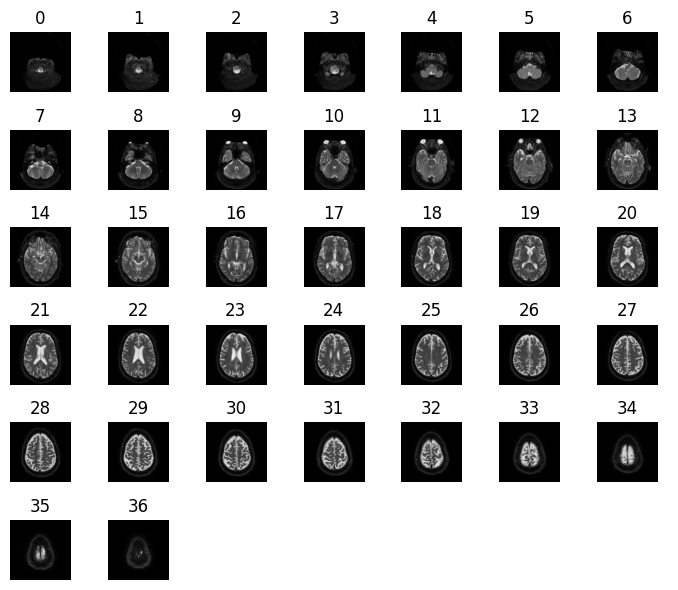

In [ ]:
plot_image_slices(mr_series_array, save_path='mr_series_wo_preprocessing')

In [ ]:
mr_mask_path = os.path.join(seg_dir, mr_series_uid+'_cowseg.nii')
mr_mask_array = load_nii(mr_mask_path)
print(clr.B+'Mask shape:'+clr.E)
print(mr_mask_array.shape)

Mask shape:
(37, 512, 512)


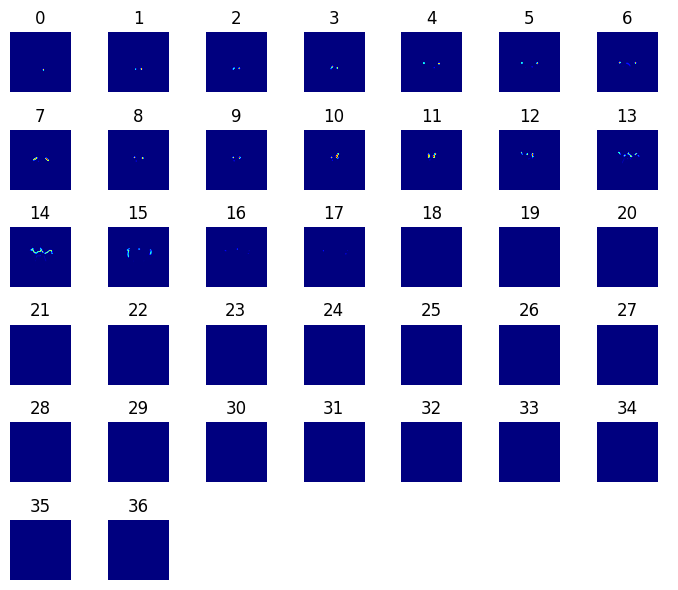

In [ ]:
plot_image_slices(mr_mask_array, save_path='mr_mask_wo_preprocessing', cmap='jet')

## Skull-Stripping

Skull stripping refers to the process of removing the skull and other non-brain tissues (e.g., scalp, muscle, fat) from brain MRI or CT images. The goal is to isolate the brain tissue for further analysis, particularly for tasks like segmentation, registration, and modeling of brain structures.

It removes irrelevant structures (e.g., skull, scalp), ensuring that models focus on the arterial system and brain tissue, which is the **region of interest (ROI)** for medical imaging tasks such as intracranial aneurysm detection.

We will be using [SynthStrip](https://surfer.nmr.mgh.harvard.edu/docs/synthstrip/) to generate masks. It supports both CPU and GPU execution.

In [ ]:
def apply_skull_stripping(series_uid):

    series_nii_path = os.path.join(seg_dir, series_uid+'.nii')
    ss_output_path = f"{mr_series_uid}_output.nii.gz"
    ss_mask_path = f"{mr_series_uid}_mask.nii.gz"

    from nipreps.synthstrip.cli import main

    sys.argv = [
        "synthstrip",
        "--image", series_nii_path,
        "--out", ss_output_path,
        "--mask", ss_mask_path,
        "--model", "/kaggle/input/synthstrip/pytorch/main/1/synthstrip.1.pt",
    ]

    main()

    ss_output_array = load_nii(ss_output_path)
    ss_mask_array = load_nii(ss_mask_path)
    ss_array = ss_mask_array * mr_series_array

    return ss_array, ss_mask_array

In [ ]:
mr_ss_array, mr_ss_mask_array = apply_skull_stripping(mr_series_uid)

Configuring model on the CPU
Using custom model weights
Input image read from: /kaggle/input/rsna-intracranial-aneurysm-detection/segmentations/1.2.826.0.1.3680043.8.498.92498800238576582506105430510381134234.nii
Masked image saved to: 1.2.826.0.1.3680043.8.498.92498800238576582506105430510381134234_output.nii.gz
Binary brain mask saved to: 1.2.826.0.1.3680043.8.498.92498800238576582506105430510381134234_mask.nii.gz
If you use SynthStrip in your analysis, please cite:
----------------------------------------------------
SynthStrip: Skull-Stripping for Any Brain Image.
A Hoopes, JS Mora, AV Dalca, B Fischl, M Hoffmann.


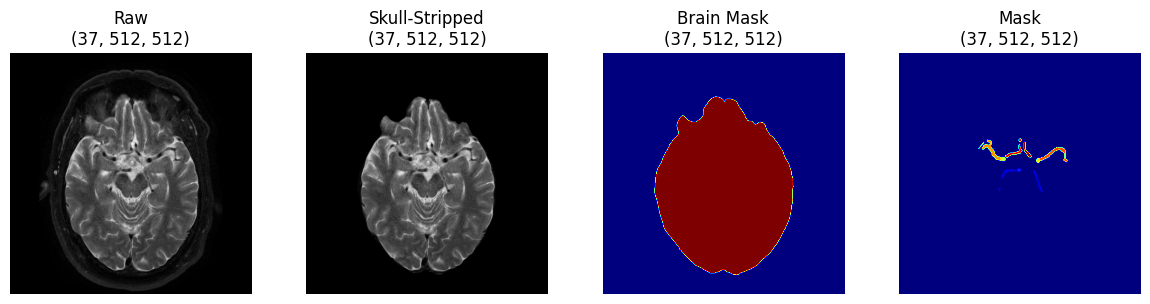

In [ ]:
plot_preprocessing_process({
    'Raw': mr_series_array,
    'Skull-Stripped': mr_ss_array,
    'Brain Mask': mr_ss_mask_array,
    'Mask': mr_mask_array
})

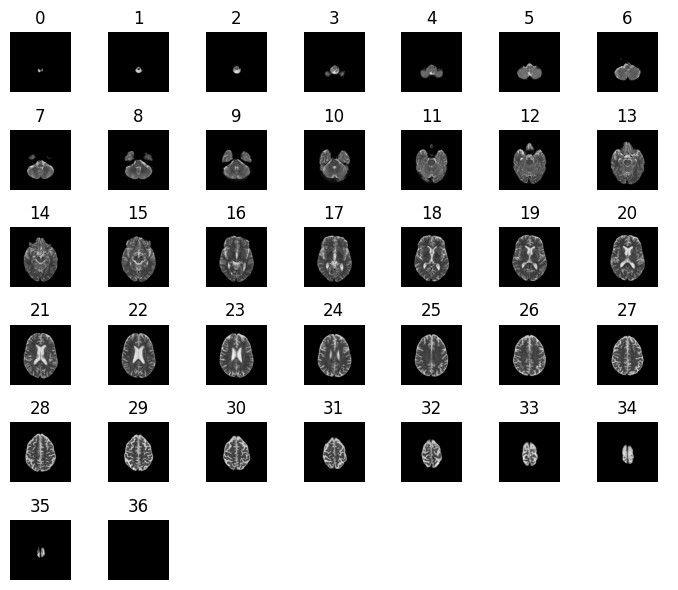

In [ ]:
plot_image_slices(mr_ss_array, save_path='mr_mask_w_skull_stripping')

## N4 Bias-Field Correction


A **bias field** (or **intensity inhomogeneity**) refers to the slow, spatially-varying intensity variation in an image that is typically caused by imperfections in the acquisition process. This bias is not related to any biological tissue property and is often caused by the MRI scanner’s magnetic field heterogeneity, coil sensitivity, or gradients. As a result, certain regions in the image (e.g., areas further from the center of the scanner) may appear brighter or darker than others, even if the tissue properties are homogeneous.

![n4_bias_field](https://raw.githubusercontent.com/ammomahdavikia/asset-holding/main/n4_bias_field.png)

**N4** is an effective method for correcting bias field artifacts, and it’s widely used in neuroimaging pipelines, particularly for brain scans like MRI. It iterates through the image, updating both the bias field and the corrected image to minimize the difference between the original and the corrected image based on a statistical model.

In [ ]:
def apply_n4_correction(array: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    image_sitk = sitk.GetImageFromArray(array)
    image_sitk = sitk.Cast(image_sitk, sitk.sitkFloat32)

    # Create mask using Otsu's method
    mask = sitk.OtsuThreshold(image_sitk, 0, 1, 200)

    # Set up N4 Bias Field Correction
    # Optimization Note: While SimpleITK runs on CPU, for large-scale cohort processing (n>10,000),
    # this step is the bottleneck. In the production pipeline, we utilize the GPU-accelerated
    # implementation (e.g., cuCIM or MONAI) to reduce processing time from ~50s to <5s per volume.
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.SetMaximumNumberOfIterations([50, 30, 20])

    start_time = time.time()
    corrected_sitk = corrector.Execute(image_sitk, mask)
    elapsed_time = time.time() - start_time

    corrected_array = sitk.GetArrayFromImage(corrected_sitk)

    print(clr.B+f"N4 Bias Field Correction took {elapsed_time:.2f} seconds"+clr.E)

    log_bias_field = corrector.GetLogBiasFieldAsImage(image_sitk)
    bias_field = sitk.Exp(log_bias_field)  # multiplicative bias map
    bias_array = sitk.GetArrayFromImage(bias_field)

    return corrected_array, bias_array

In [ ]:
mr_corrected_array, mr_bias_array = apply_n4_correction(mr_ss_array)

N4 Bias Field Correction took 66.54 seconds


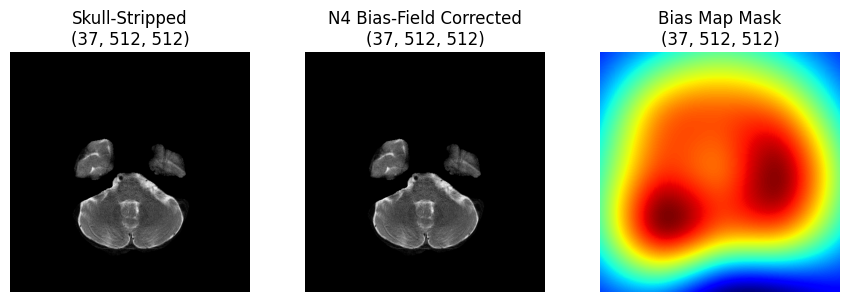

In [ ]:
plot_preprocessing_process({
    'Skull-Stripped': mr_ss_array,
    'N4 Bias-Field Corrected': mr_corrected_array,
    'Bias Map Mask': mr_bias_array
})

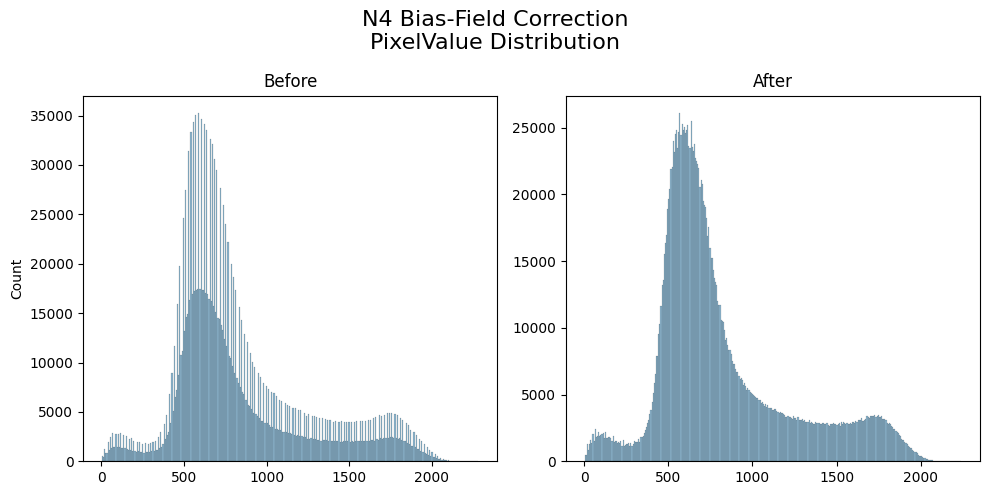

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.histplot(mr_ss_array[mr_ss_array>0].flatten(), color=COLORS[4], ax=axs[0])
axs[0].set_title('Before')
sns.histplot(mr_corrected_array[mr_corrected_array>0].flatten(), color=COLORS[4], ax=axs[1])
axs[1].set_title('After')
axs[1].set_ylabel('')

fig.suptitle('N4 Bias-Field Correction\nPixelValue Distribution', fontsize=16)
fig.tight_layout()
fig.show()
fig.savefig('figures/n4_bias_field_correction.png', dpi=300)

As you can see, the N4 Bias-Field correction smooths the pixel value distribution, reducing intensity inhomogeneity across the MRI.

## [MR] Intensity Normalization

In [ ]:
mr_z_normalized_array = apply_normalization(mr_corrected_array, 'z-score')

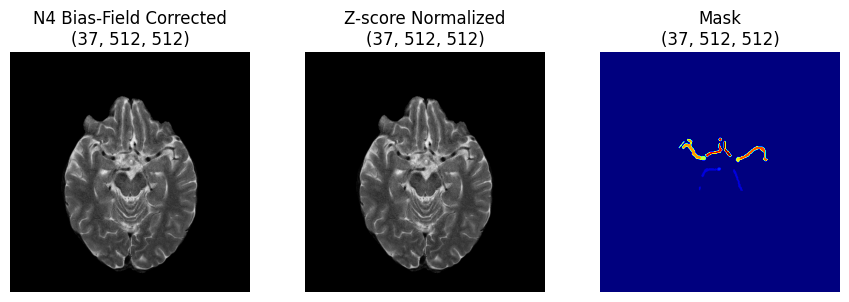

In [ ]:
plot_preprocessing_process({
    'N4 Bias-Field Corrected': mr_corrected_array,
    'Z-score Normalized': mr_z_normalized_array,
    'Mask': mr_mask_array
})

In [ ]:
mr_mm_normalized_array = apply_normalization(mr_corrected_array, 'min-max')

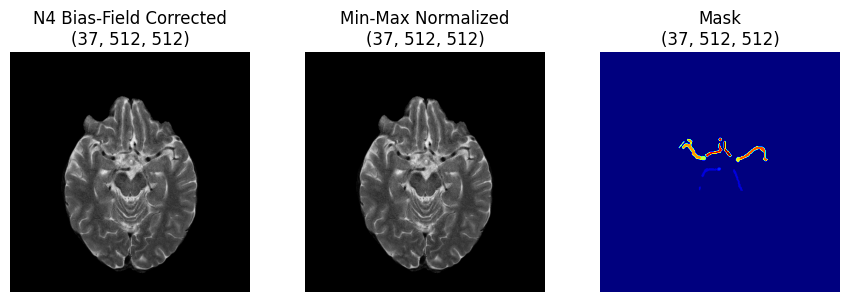

In [ ]:
plot_preprocessing_process({
    'N4 Bias-Field Corrected': mr_corrected_array,
    'Min-Max Normalized': mr_mm_normalized_array,
    'Mask': mr_mask_array
})

## [MR] Resampling

In [ ]:
mr_dcm = pydicom.dcmread(glob(os.path.join(mr_series_dir, '*.dcm'))[0])
mr_pixel_spacing = mr_dcm.get('PixelSpacing')
mr_slice_thickness = mr_dcm.get('SliceThickness')
mr_spacing_slices = mr_dcm.get('SpacingBetweenSlices')
print(clr.B+'PixelSpacing:'+clr.E)
print(mr_pixel_spacing)
print(clr.B+'\nSliceThickness:'+clr.E)
print(mr_slice_thickness)
print(clr.B+'\nSpacingBetweenSlices:'+clr.E)
print(mr_spacing_slices)

PixelSpacing:
[0.44921875, 0.44921875]

SliceThickness:
4

SpacingBetweenSlices:
4


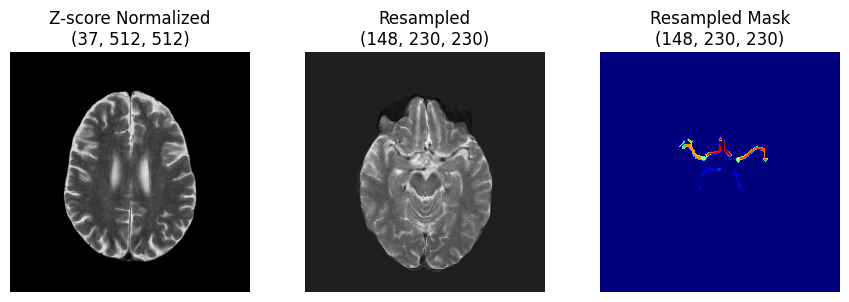

Raw array:
Shape: (37, 512, 512)
Mean: -0.0 Max: 5.63 Min: -0.43

Resampled array:
Shape: (148, 230, 230)
Mean: 0.01 Max: 5.9 Min: -1.72


In [ ]:
mr_resampled_array = apply_resampling(
    mr_z_normalized_array,
    pixel_spacing_x=mr_pixel_spacing[0],
    pixel_spacing_y=mr_pixel_spacing[1],
    pixel_spacing_z=mr_spacing_slices if mr_spacing_slices else mr_slice_thickness,
    target_spacing=(1.0, 1.0, 1.0),
)

mr_resampled_mask = apply_resampling(
    mr_mask_array,
    pixel_spacing_x=mr_pixel_spacing[0],
    pixel_spacing_y=mr_pixel_spacing[1],
    pixel_spacing_z=mr_spacing_slices if mr_spacing_slices else mr_slice_thickness,
    target_spacing=(1.0, 1.0, 1.0),
    is_mask=True
)

plot_preprocessing_process({
    'Z-score Normalized': mr_z_normalized_array,
    'Resampled': mr_resampled_array,
    'Resampled Mask': mr_resampled_mask
})

print(clr.L+"Raw array:"+clr.E)
print(clr.L+'Shape:'+clr.E, mr_z_normalized_array.shape)
print(clr.L+'Mean:'+clr.E, mr_z_normalized_array.mean().round(2), clr.L+'Max:'+clr.E, mr_z_normalized_array.max().round(2), clr.L+'Min:'+clr.E, mr_z_normalized_array.min().round(2))
print(clr.T+"\nResampled array:"+clr.E)
print(clr.T+'Shape:'+clr.E, mr_resampled_array.shape)
print(clr.T+'Mean:'+clr.E, mr_resampled_array.mean().round(2), clr.T+'Max:'+clr.E, mr_resampled_array.max().round(2), clr.T+'Min:'+clr.E, mr_resampled_array.min().round(2))

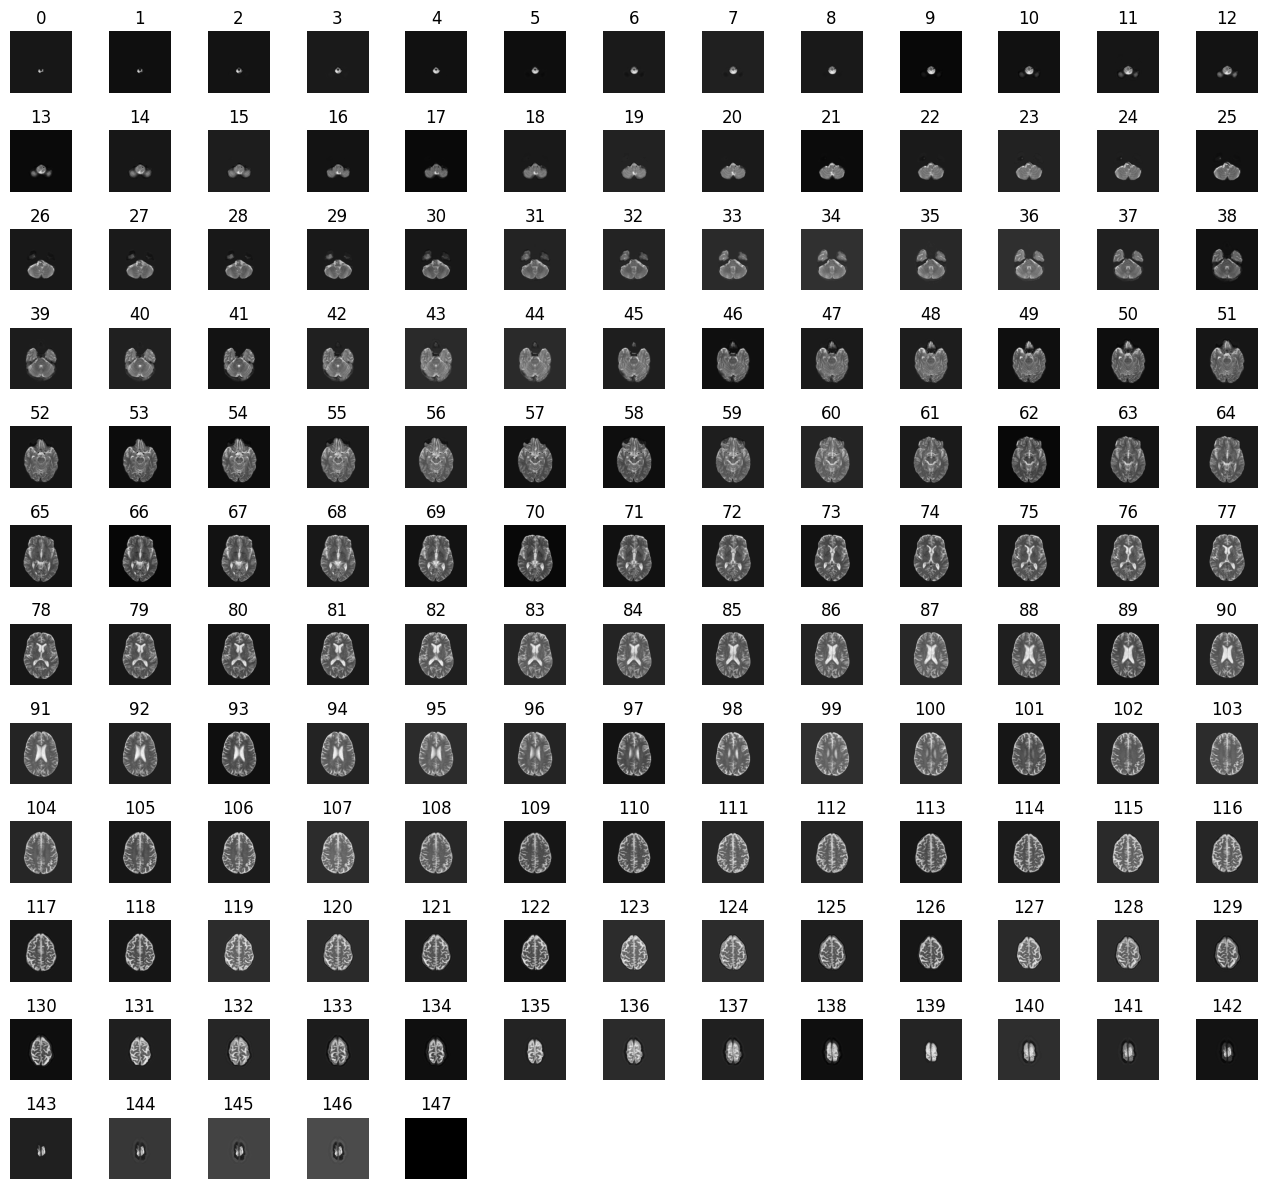

In [ ]:
plot_image_slices(mr_resampled_array, 'mr_series_w_resampling')

## [MR] Process

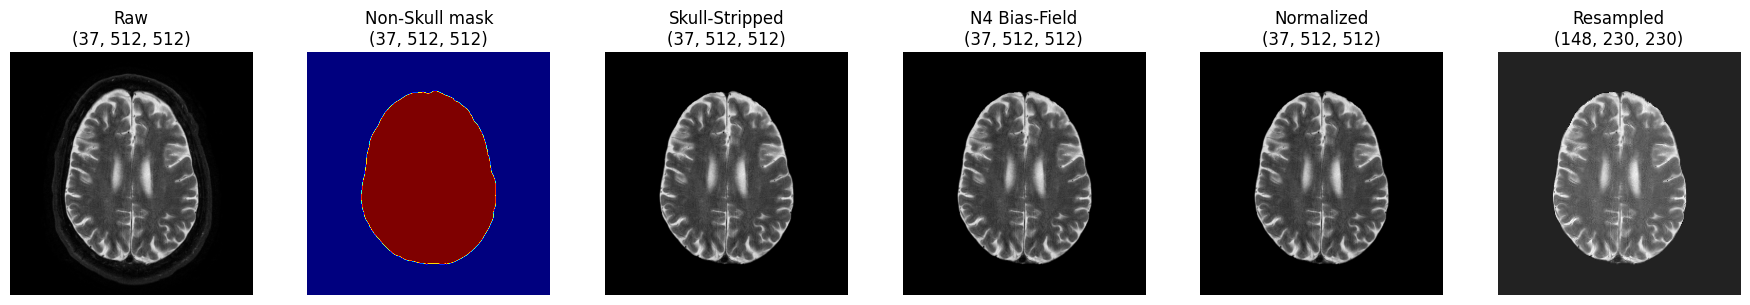

In [ ]:
plot_preprocessing_process(
    {'Raw': mr_series_array,
     'Non-Skull mask': mr_ss_mask_array,
     'Skull-Stripped': mr_ss_array,
     'N4 Bias-Field': mr_corrected_array,
     'Normalized': mr_z_normalized_array,
     'Resampled': mr_resampled_array}
)

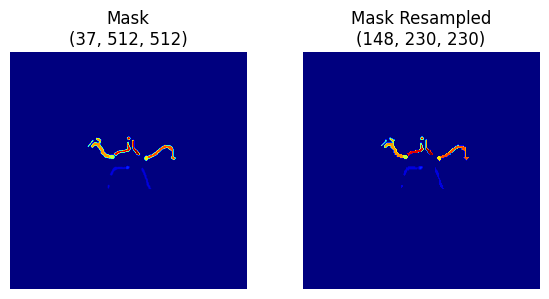

In [ ]:
plot_preprocessing_process(
    {'Mask': mr_mask_array,
     'Mask Resampled': mr_resampled_mask}
)

# <div style="text-align:center; border-radius:10px; color:black; margin:0; font-size:100%; font-family:Carbon Plus; background-color:white; overflow:hidden"><b>Summary</b></div>

![preprocessing_summary](https://raw.githubusercontent.com/ammomahdavikia/asset-holding/main/preprocessing_summary.png)

## Next Steps: Pipeline Integration

The preprocessed 3D volumes (196x196xZ) are now standardized and ready for downstream modeling.

**Deep Network Ingestion:**
1. **Patch Extraction:** Sliding window inference is used to handle variable z-depths.
2. **Augmentation:** 3D rotations and elastic deformations are applied on-the-fly during training.
3. **Model:** These inputs feed directly into the Graph Neural Network / 3D-ResNet backbone for aneurysm detection.

# <div style="text-align:center; border-radius:10px; color:black; margin:0; font-size:100%; font-family:Carbon Plus; background-color:white; overflow:hidden"><b>References</b></div>

1. Song, M., Wang, S., Qian, Q., Zhou, Y., Luo, Y. & Gong, X. Intracranial aneurysm CTA images and 3D models dataset with clinical morphological and hemodynamic data. *Sci. Data* **11**, 1213 (2024). [https://www.nature.com/articles/s41597-024-04056-8](https://www.nature.com/articles/s41597-024-04056-8)

2. Di Noto, T., Marie, G., Tourbier, S., Alemán-Gómez, Y., Esteban, O., Saliou, G., Bach Cuadra, M., Hagmann, P. & Richiardi, J. Towards Automated Brain Aneurysm Detection in TOF-MRA: open data, weak labels, and anatomical knowledge. *Neuroinformatics* **21**, 21–34 (2023). [https://link.springer.com/article/10.1007/s12021-022-09597-0](https://link.springer.com/article/10.1007/s12021-022-09597-0)

3. Ham, S., Seo, J., Yun, J., Bae, Y. J., Kim, T., Sunwoo, L., Yoo, S., Jung, S. C., Kim, J.-W. & Kim, N. Automated detection of intracranial aneurysms using skeleton-based 3D patches, semantic segmentation, and auxiliary classification for overcoming data imbalance in brain TOF-MRA. *Sci. Rep.* **13**, 12018 (2023). [https://www.nature.com/articles/s41598-023-38586-9](https://www.nature.com/articles/s41598-023-38586-9)

4. Deshpande, A., Jamilpour, N., Jiang, B., Kidwell, C., Wintermark, M. & Laksari, K. Automatic Segmentation, Feature Extraction and Comparison of Healthy and Stroke Cerebral Vasculature. *arXiv* preprint (2020). [https://arxiv.org/pdf/2002.11208](https://arxiv.org/pdf/2002.11208)

5. Li, X., Morgan, P. S., Ashburner, J., Smith, J. & Rorden, C. The first step for neuroimaging data analysis: DICOM to NIfTI conversion. *J. Neurosci. Methods* **264**, 47–56 (2016). [https://pubmed.ncbi.nlm.nih.gov/26945974/](https://pubmed.ncbi.nlm.nih.gov/26945974/)

6. Hoopes, A., Mora, J. S., Dalca, A. V., Fischl, B.* & Hoffmann, M.* SynthStrip: Skull-Stripping for Any Brain Image. *NeuroImage* **260**, 119474 (2022). https://doi.org/10.1016/j.neuroimage.2022.119474